In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import shap

from pathlib import Path
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier

from context import wfm

shap.initjs()


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
root_path = Path().resolve().parent
input_path = root_path / "data" / "input"
images_path = root_path / "images"
output_path = root_path / "output"

input_data = wfm.preprocessing.get_input_data(input_path)
input_data.head()

,wildfire,id,año,material,npisos,h_viv,n_daño,orientacio,elevación,pendiente,...,fact_agua,n_conjman,d_conj_man,n_conj10m,d_conj_10m,n_conj20m,d_conj_20m,cord_x,cord_y,geometry
0,Limache,0,1978.0,Sólido,1.0,2.5,Ninguno,E,67.4828,11.326300,...,No,6,10.0000,13,10.0000,4,20.0000,291295.0,6347530.0,"POLYGON ((291288.520 6347524.396, 291294.786 6..."
1,Limache,0,2004.0,Liviano,1.0,2.5,Ninguno,E,67.9629,10.550100,...,No,6,10.0000,13,10.0000,4,20.0000,291301.0,6347550.0,"POLYGON ((291298.638 6347547.595, 291299.696 6..."
2,Limache,0,2009.0,Liviano,1.0,2.5,Ninguno,E,64.9530,10.819000,...,No,6,10.0000,13,10.0000,4,20.0000,291300.0,6347520.0,"POLYGON ((291298.469 6347519.147, 291300.967 6..."
3,Limache,0,1978.0,Liviano,1.0,2.5,Ninguno,E,61.4631,0.953306,...,No,6,10.0000,12,10.0000,4,20.0000,291334.0,6347500.0,"POLYGON ((291329.666 6347502.326, 291340.503 6..."
4,Limache,0,1978.0,Sólido,1.0,2.5,Ninguno,E,61.5823,0.693135,...,No,6,23.5041,12,23.5041,4,37.6067,291371.0,6347510.0,"POLYGON ((291363.407 6347527.937, 291365.271 6..."


In [3]:
input_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   wildfire    2694 non-null   category
 1   id          2694 non-null   int64   
 2   año         2694 non-null   float64 
 3   material    2417 non-null   category
 4   npisos      2694 non-null   float64 
 5   h_viv       2694 non-null   float64 
 6   n_daño      2694 non-null   category
 7   orientacio  2693 non-null   category
 8   elevación   2694 non-null   float64 
 9   pendiente   2694 non-null   float64 
 10  dist_veget  2694 non-null   float64 
 11  dist_foco   2694 non-null   float64 
 12  dist_estru  2694 non-null   float64 
 13  tamaño      2694 non-null   float64 
 14  codigo_pol  2694 non-null   int64   
 15  sup_viv_ha  2694 non-null   float64 
 16  raz_ocup    2694 non-null   int64   
 17  prep_vivie  2694 non-null   category
 18  mant_viv    2439 non-null   category
 19

In [42]:
# input_data = input_data.fillna("0")

# --- Split data 
split_random_state = 42
X = (
    input_data.drop(columns=["wildfire", "id", "n_daño", "geometry", "orientacio", "mant_viv"])
    .pipe(lambda df: pd.DataFrame(df))
)
# X = X.select_dtypes("number")
# from sklearn import preprocessing
# target_encoder = preprocessing.LabelEncoder()
# target_encoder.fit(input_data["n_daño"])
# y = target_encoder.transform(input_data["n_daño"])
y = input_data["n_daño"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=split_random_state
)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"{y_train.size} train records and {y_test.size} test records.")

X shape: (2694, 25)
y shape: (2694,)
2020 train records and 674 test records.


In [26]:
# # --- Preprocessing
# categorical_columns = X.select_dtypes("object").columns.tolist()
# numerical_columns = X.select_dtypes("number").columns.tolist()
# preprocessor = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore"), categorical_columns),
#     remainder="passthrough"
# )

In [27]:
from sklearn.compose import ColumnTransformer

In [28]:
from sklearn.pipeline import Pipeline

In [29]:
from sklearn.impute import SimpleImputer

In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [43]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [50]:
categorical_transformer.fit_transform(input_data[["fact_agua"]])

<2694x4 sparse matrix of type '<class 'numpy.float64'>'
	with 2694 stored elements in Compressed Sparse Row format>

In [44]:
from sklearn.compose import make_column_selector as selector

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selector(dtype_exclude="category")),
        ('cat', categorical_transformer, selector(dtype_include="category"))
    ]
)
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


In [45]:
from sklearn import set_config

set_config(display='diagram')
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fde6e0bcf40>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fde6e0bcfd0>)])),
                ('classifier', RandomForestClassifier())])

In [46]:
from sklearn.metrics import classification_report

In [47]:
_ = model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print(
    classification_report(
        y_test,
        y_pred_test,
    )
)

ValueError: Input contains NaN

In [40]:
# # --- Model
# model = make_pipeline(
#     # imputer,
#     preprocessor,
#     RandomForestClassifier(
#         n_estimators=10,
#         n_jobs=-1,
#         random_state=42,
#     )
# )

# _ = model.fit(X_train, y_train)
# y_pred_test = model.predict(X_test)
# print(
#     classification_report(
#         y_test,
#         y_pred_test,
#     )
# )

In [15]:
from sklearn.metrics import plot_confusion_matrix

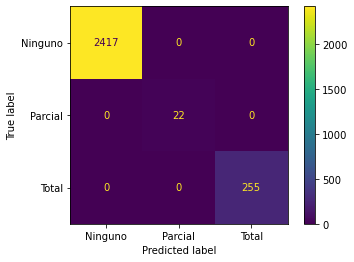

In [16]:
plot_confusion_matrix(model, X, y) 

In [19]:
explainer = shap.Explainer(model.predict, X)

In [26]:
X.iloc[i, :]

año                  1978
material           Sólido
npisos                  1
h_viv                 2.5
orientacio              E
elevación         67.4828
pendiente         11.3263
dist_veget         1.1378
dist_foco         238.502
dist_estru        4.35384
tamaño            139.054
codigo_pol              1
sup_viv_ha      0.0139054
raz_ocup                0
prep_vivie             No
mant_viv               Si
acceso_equ        Directo
ac_supresi         Equipo
fact_agua              No
n_conjman               6
d_conj_man             10
n_conj10m              13
d_conj_10m             10
n_conj20m               4
d_conj_20m             20
cord_x             291295
cord_y        6.34753e+06
Name: 0, dtype: object

In [28]:
# explainer = shap.TreeExplainer(model)
# explainer = 
for i in range(X.shape[0]):
    try:
        shap_values = explainer.shap_values(X.iloc[i:])
        print("i")
    except:
        pass

In [50]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer.shap_values(X)

Permutation explainer: 2695it [08:33,  5.25it/s]                          


AttributeError: 'Explanation' object has no attribute '_old_format'

In [52]:
explainer.feature_names

In [ ]:
shap.summary_plot(shap_values, X, show=False)

In [76]:
model.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('scaler', StandardScaler())]),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0591b27290>),
                                 ('cat', OneHotEncoder(handle_unknown='ignore'),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f0591b27590>)]),
 'classifier': RandomForestClassifier()}

In [77]:
model.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('scaler', StandardScaler())]),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f0591b27290>),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f0591b27590>)])),
 ('classifier', RandomForestClassifier())]

In [81]:
type(model)

sklearn.pipeline.Pipeline

In [82]:
type(model["preprocessor"])

sklearn.compose._column_transformer.ColumnTransformer

In [84]:
model["preprocessor"].named_transformers_["cat"]

OneHotEncoder(handle_unknown='ignore')

## Simple Feature Importance

In [66]:
model["classifier"].feature_importances_

array([1.16900258e-03, 1.86422321e-01, 1.82870008e-01, 4.18040033e-03,
       1.83750318e-03, 1.10589615e-03, 9.11002091e-03, 3.39741366e-03,
       2.70208109e-03, 1.43529749e-01, 4.00473759e-03, 1.46961674e-03,
       2.41563205e-03, 1.00470625e-03, 3.27016298e-03, 7.62414035e-04,
       5.67042548e-04, 1.27245145e-03, 1.23685506e-02, 5.85297129e-03,
       4.23223427e-02, 1.93277895e-03, 5.59996858e-04, 1.73153399e-01,
       5.58622362e-04, 1.61362589e-05, 9.11648337e-05, 1.66895120e-04,
       2.58319431e-04, 3.31908990e-04, 1.24608643e-04, 0.00000000e+00,
       7.09718105e-04, 5.66297283e-04, 4.78130350e-02, 1.36761677e-02,
       1.39814542e-01, 1.98908882e-03, 2.42148823e-03, 2.10466011e-04,
       2.18058747e-04, 1.99291008e-03, 1.09977580e-03, 1.04897807e-04,
       2.23132491e-04, 3.31567925e-04])

In [75]:
model.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('scaler', StandardScaler())]),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f0591b27290>),
                                  ('cat', OneHotEncoder(handle_unknown='ignore'),
                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f0591b27590>)])),
 ('classifier', RandomForestClassifier())]

In [68]:
len(model["classifier"].feature_importances_)

46

In [69]:
X.shape

(2694, 27)

In [85]:
from sklearn.inspection import permutation_importance

In [37]:
categorical_columns = [
    'material',
 'orientacio',
 'prep_vivie',
 'mant_viv',
 'acceso_equ',
 'ac_supresi',
 'fact_agua'
]
numerical_columns = wfm.NUM_COLUMNS

In [38]:
ohe = (model.named_steps['preprocessor']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    model.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(8, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

ValueError: input_features should have length equal to number of features (0), got 7

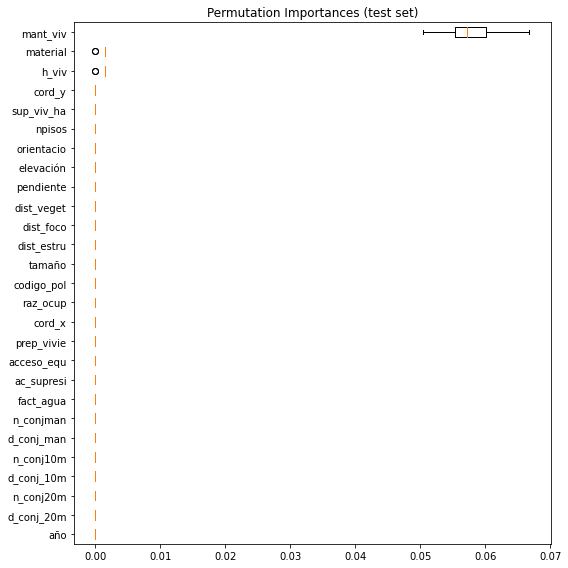

In [104]:
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=3)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

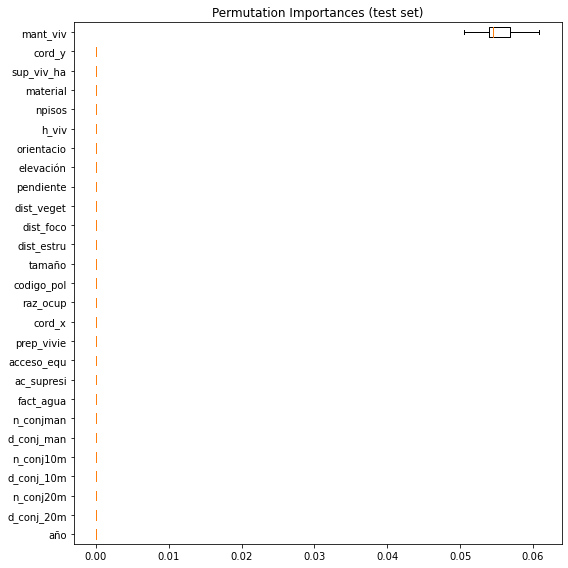

In [106]:
result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=3)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [100]:
feature_importances = pd.DataFrame(
    model["classifier"].feature_importances_,
    columns=['Coefficients'],
    index=X.columns
)

feature_importances.sort_values("Coefficients").plot(kind='barh', figsize=(9, 7))
plt.title('Random Forest')
plt.axvline(x=0, color='.5')
# plt.subplots_adjust(left=.3)

ValueError: Shape of passed values is (46, 1), indices imply (27, 1)

In [73]:
from sklearn.model_selection import cross_validate, RepeatedKFold, RepeatedStratifiedKFold


In [74]:
cv_model = cross_validate(
    model,
    X,
    y,
    scoring=["r2", "neg_root_mean_squared_error"],
    cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=30, random_state=42),
    return_train_score=True,
    return_estimator=True,
    n_jobs=-1
)
coefs = pd.DataFrame(
    [est.feature_importances_ for est in cv_model['estimator']],
    columns=X.columns
)

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [ ]:
model.ste

In [18]:
# All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric.

Text(0.5, 1.0, 'R2 Score for train and test sets')

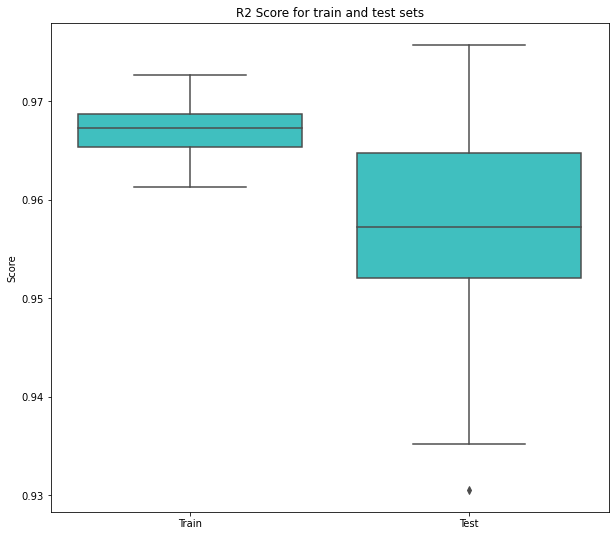

In [19]:
cv_scores = pd.DataFrame({"Train": cv_model['train_r2'], "Test": cv_model['test_r2']})
plt.figure(figsize=(10, 9))
sns.boxplot(data=cv_scores, orient='v', color='cyan', saturation=0.5)
plt.ylabel('Score')
plt.title('R2 Score for train and test sets')
# plt.subplots_adjust(left=.3)

Text(0.5, 1.0, 'RMSE for train and test sets')

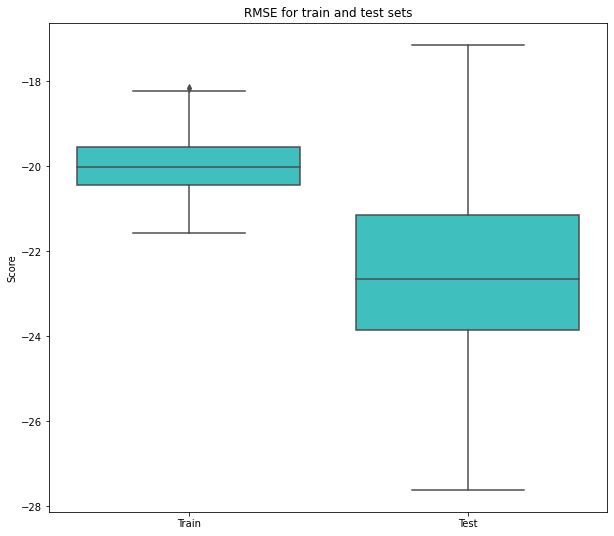

In [20]:
cv_scores = pd.DataFrame({"Train": cv_model['train_neg_root_mean_squared_error'], "Test": cv_model['test_neg_root_mean_squared_error']})
plt.figure(figsize=(10, 9))
sns.boxplot(data=cv_scores, orient='v', color='cyan', saturation=0.5)
plt.ylabel('Score')
plt.title('RMSE for train and test sets')
# plt.subplots_adjust(left=.3)

Text(0.5, 1.0, 'Feature importance and its variability')

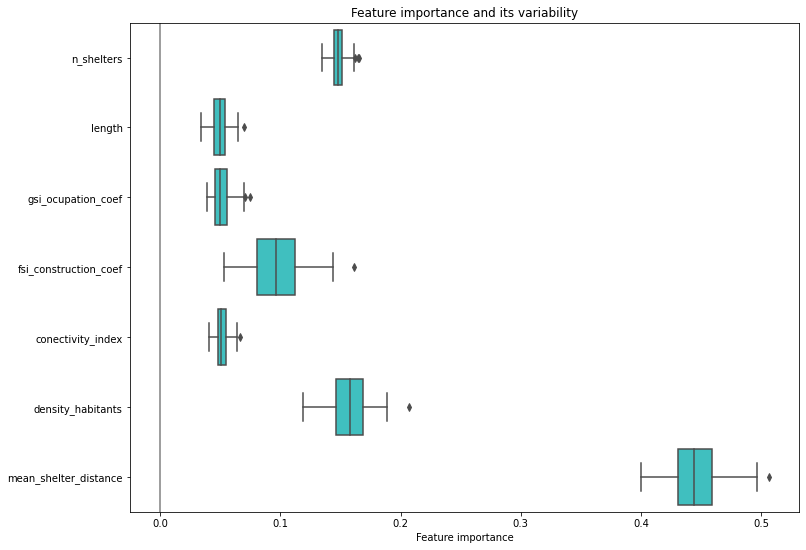

In [21]:
plt.figure(figsize=(12, 9))
# sns.swarmplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Feature importance')
plt.title('Feature importance and its variability')
# plt.subplots_adjust(left=.3)

In [109]:
shap_kernel_explainer = shap.KernelExplainer(model, X_train)
# shap_values_single = shap_kernel_explainer.shap_values(x_test.iloc[0,:])
# shap.force_plot(shap_kernel_explainer.expected_value[0],np.array(shap_values_single[0]), x_test.iloc[0,:],link='logit')

Provided model function fails when applied to the provided data set.


TypeError: 'Pipeline' object is not callable